# Deep learning in genomics

This notebook is based on the [jupyter notebook](https://github.com/abidlabs/deep-learning-genomics-primer/blob/master/A_Primer_on_Deep_Learning_in_Genomics_Public.ipynb) from the publication ["A primer on deep learning in genomics"](https://www.nature.com/articles/s41588-018-0295-5) but uses the [fastai](https://www.fast.ai) library based on [PyTorch](https://pytorch.org).

# Notebook setup

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [4]:
# fastai version
__version__

'1.0.32.dev0'

# Data setup

## Data preprocessing (not needed, go to "Data loading")

In [5]:
import requests

In [6]:
URL_seq = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/sequences.txt'

In [7]:
# get data from URL
seq_raw = requests.get(URL_seq).text.split('\n')
seq_raw = list(filter(None, seq_raw)) # Removes empty lists

In [8]:
# check length
len(seq_raw)

2000

In [9]:
# setup df from list
seq_df = pd.DataFrame(seq_raw, columns=['Sequences'])

In [10]:
# show head of dataframe
#seq_df.head()

In [11]:
URL_labels = 'https://raw.githubusercontent.com/abidlabs/deep-learning-genomics-primer/master/labels.txt'

In [12]:
seq_labels = requests.get(URL_labels).text.split('\n')
seq_labels = list(filter(None, seq_labels)) # Removes empty entries

In [13]:
len(seq_labels)

2000

In [14]:
seq_label_series = pd.Series(seq_labels)

In [15]:
seq_df['Target'] = seq_label_series.astype('int')

In [16]:
seq_df.head()

,Sequences,Target
0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [17]:
seq_df.to_csv('seq_df.csv')

## Data loading

In [5]:
seq_df = pd.read_csv('seq_df.csv')

In [8]:
seq_df.head()

,Unnamed: 0,Sequences,Target
0,0,CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGA...,0
1,1,GAGTTTATATGGCGCGAGCCTAGTGGTTTTTGTACTTGTTTGTCGC...,0
2,2,GATCAGTAGGGAAACAAACAGAGGGCCCAGCCACATCTAGCAGGTA...,0
3,3,GTCCACGACCGAACTCCCACCTTGACCGCAGAGGTACCACCAGAGC...,1
4,4,GGCGACCGAACTCCAACTAGAACCTGCATAACTGGCCTGGGAGATA...,1


In [7]:
seq_df['Target'].values

array([0, 0, 0, 1, ..., 1, 0, 1, 1])

## Data encoding test (incorporated into "open_seq_image" function)

In [86]:
# setup class instance to encode the four different bases to integer values (1D)
int_enc = LabelEncoder()

In [87]:
# setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
one_hot_enc = OneHotEncoder(categories=[range(4)])

In [88]:
seq_enc = []

for s in seq:
    enc = int_enc.fit_transform(list(s)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    seq_enc.append(enc.toarray()) # export sparse matrix to np array

In [89]:
len(seq_enc)

2000

In [462]:
seq_enc[0].T, seq_enc[0].T.shape

(array([[0., 0., 0., 1., ..., 0., 1., 0., 0.],
        [1., 1., 0., 0., ..., 1., 0., 1., 1.],
        [0., 0., 1., 0., ..., 0., 0., 0., 0.],
        [0., 0., 0., 0., ..., 0., 0., 0., 0.]]), (4, 50))

In [311]:
PIL.Image.fromarray(seq_enc[0].T.astype('uint8')*255).convert('P')

## Data setup for NN

In [9]:
# open sequence image function
def open_seq_image(seq:str, cls:type=Image)->Image:
    "Return `Image` object created from sequence string `seq`."
    
    int_enc = LabelEncoder() # setup class instance to encode the four different bases to integer values (1D)
    one_hot_enc = OneHotEncoder(categories=[range(4)]) # setup one hot encoder to encode integer encoded classes (1D) to one hot encoded array (4D)
    
    enc = int_enc.fit_transform(list(seq)) # bases (ACGT) to int (0,1,2,3)
    enc = np.array(enc).reshape(-1,1) # reshape to get rank 2 array (from rank 1 array)
    enc = one_hot_enc.fit_transform(enc) # encoded integer encoded bases to sparse matrix (sparse matrix dtype)
    enc = enc.toarray().T # export sparse matrix to np array
    #print('enc', enc, enc.shape)
    
    # https://stackoverflow.com/questions/22902040/convert-black-and-white-array-into-an-image-in-python
    x = PIL.Image.fromarray(enc.astype('uint8')).convert('P')
    x = pil2tensor(x,np.float32)
    #x = x.view(4,-1) # remove first dimension
    #x = x.expand(3, 4, 50) # expand to 3 channel image
    #print('x', x, x.shape)
    return cls(x)

In [10]:
# test open sequence image function
open_seq_image('CCGAGGGCTATGGTTTGGAAGTTAGAACCCTGGGGCTTCTCGCGGACACC')

In [11]:
class SeqItemList(ImageItemList):
    _bunch,_square_show = ImageDataBunch,True
    def __post_init__(self):
        super().__post_init__()
        self.sizes={}
    
    def open(self, seq): return open_seq_image(seq)
    
    def get(self, i):
        seq = self.items[i][0]
        res = self.open(seq)
        return res
    
    @classmethod
    def import_from_df(cls, df:DataFrame, cols:IntsOrStrs=0, **kwargs)->'ItemList':
        "Get the sequences in `col` of `df` and will had `path/folder` in front of them, `suffix` at the end."
        return cls(items=df[cols].values)

In [75]:
data = (SeqItemList.import_from_df(seq_df, ['Sequences'])
        .random_split_by_pct(valid_pct=0.25)
        #.split_by_idxs(range(1500), range(1500,2000))
        .label_from_list(seq_df['Target'].values)
        .databunch())

In [76]:
data

ImageDataBunch;
Train: LabelList
y: CategoryList (2000 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: .
x: SeqItemList (1500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;
Valid: LabelList
y: CategoryList (2000 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: .
x: SeqItemList (500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;
Test: None

In [14]:
i = 2
data.x[i]

In [15]:
data.y[i]

Category 0

In [16]:
i = 3
data.x[i]

In [17]:
data.y[i]

Category 1

In [18]:
data.train_ds[0]#, data.train_ds.classes

(Image (1, 4, 50), Category 0)

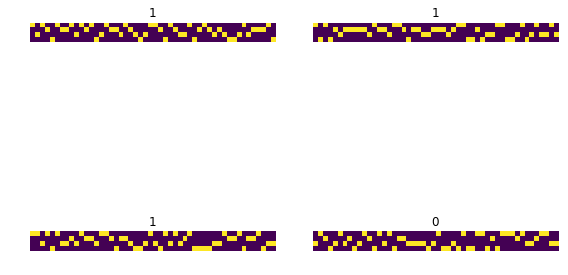

In [19]:
data.show_batch(rows=2)

# Model setup

## Lookup ResNet34 architecture (not needed, just for reference)

In [143]:
test_learn = create_cnn(data, models.resnet18)

In [144]:
test_learn.loss_func

<function torch.nn.functional.cross_entropy(input, target, weight=None, size_average=None, ignore_index=-100, reduce=None, reduction='elementwise_mean')>

In [148]:
#test_learn.model[0]

In [149]:
test_learn.model[1]

Sequential(
  (0): AdaptiveConcatPool2d(
    (ap): AdaptiveAvgPool2d(output_size=1)
    (mp): AdaptiveMaxPool2d(output_size=1)
  )
  (1): Lambda()
  (2): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

In [152]:
def ExpandInput(): return Lambda(lambda x: x.expand(-1, 3, 4, 50))

In [153]:
EI = ExpandInput()

In [ ]:
# Test ExpandInput layer

In [166]:
tt = torch.rand((64,1,4,50)); tt.shape

torch.Size([64, 1, 4, 50])

In [167]:
tt.expand(-1, 3, 4, 50).shape

torch.Size([64, 3, 4, 50])

In [168]:
Image(EI(tt)[0])

In [155]:
new_model = nn.Sequential(ExpandInput(), test_learn.model) # insert ExpandInput layer at the beginning of the network

In [156]:
new_model[0](tt).shape

torch.Size([64, 3, 4, 50])

In [159]:
new_learn = Learner(data, new_model, metrics=accuracy)

In [165]:
#[p.shape for p in new_model.parameters()]

In [160]:
new_learn.fit_one_cycle(5)

Total time: 03:42
epoch  train_loss  valid_loss  accuracy
1      0.664468    0.764640    0.532000  (00:43)
2      0.659713    0.819829    0.480000  (00:43)
3      0.635178    0.888000    0.482000  (00:49)
4      0.593556    0.875104    0.502000  (00:43)
5      0.561881    0.893715    0.472000  (00:42)



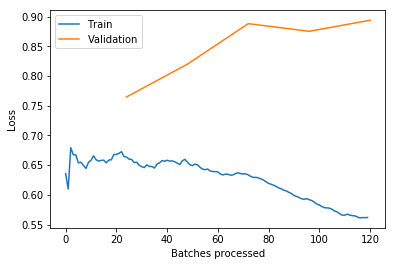

In [161]:
new_learn.recorder.plot_losses()

In [62]:
del test_learn
del new_model
del new_learn

## Setup model

In [50]:
def Flatten(): return Lambda(lambda x: x.view((x.size(0), -1)))

In [51]:
def ResizeInput(): return Lambda(lambda x: x.view((-1,)+x.size()[-2:]))

In [52]:
#def ResizeOutput(): return Lambda(lambda x: x.view(-1))

In [77]:
net = nn.Sequential(ResizeInput(),
                    nn.Conv1d(in_channels=4, out_channels=32, kernel_size=12),
                    nn.MaxPool1d(kernel_size=4),
                    Flatten(),
                    nn.Linear(in_features=288, out_features=16),
                    nn.ReLU(),
                    nn.Linear(in_features=16, out_features=2),
                    #Debugger()
                   )

In [78]:
net

Sequential(
  (0): Lambda()
  (1): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Lambda()
  (4): Linear(in_features=288, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=2, bias=True)
)

In [69]:
apply_init(net, nn.init.kaiming_normal_)

## Run sequence through network for testing

In [25]:
data.train_ds[0], data.train_ds[3]

((Image (1, 4, 50), Category 0), (Image (1, 4, 50), Category 1))

In [84]:
net(data.train_ds[0][0].data), net(data.train_ds[3][0].data)

(tensor([[0.2031, 0.2126]], grad_fn=<ThAddmmBackward>),
 tensor([[-0.2022,  1.0126]], grad_fn=<ThAddmmBackward>))

# Learner setup

## TBLogger

In [27]:
import tensorflow as tf

# From https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
"""Simple example on how to log scalars and images to tensorboard without tensor ops.
License: Copyleft
"""
#__author__ = "Michael Gygli"

#import tensorflow as tf
#from StringIO import StringIO
#import matplotlib.pyplot as plt
#import numpy as np

class Logger(object):
    """Logging in tensorboard without tensorflow ops."""

    def __init__(self, log_dir):
        """Creates a summary writer logging to log_dir."""
        self.writer = tf.summary.FileWriter(log_dir)

    def log_scalar(self, tag, value, step):
        """Log a scalar variable.
        Parameter
        ----------
        tag : basestring
            Name of the scalar
        value
        step : int
            training iteration
        """
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag,
                                                     simple_value=value)])
        self.writer.add_summary(summary, step)

    def log_images(self, tag, images, step):
        """Logs a list of images."""

        im_summaries = []
        for nr, img in enumerate(images):
            # Write the image to a string
            s = StringIO()
            plt.imsave(s, img, format='png')

            # Create an Image object
            img_sum = tf.Summary.Image(encoded_image_string=s.getvalue(),
                                       height=img.shape[0],
                                       width=img.shape[1])
            # Create a Summary value
            im_summaries.append(tf.Summary.Value(tag='%s/%d' % (tag, nr),
                                                 image=img_sum))

        # Create and write Summary
        summary = tf.Summary(value=im_summaries)
        self.writer.add_summary(summary, step)
        

    def log_histogram(self, tag, values, step, bins=1000):
        """Logs the histogram of a list/vector of values."""
        # Convert to a numpy array
        values = np.array(values)
        
        # Create histogram using numpy        
        counts, bin_edges = np.histogram(values, bins=bins)

        # Fill fields of histogram proto
        hist = tf.HistogramProto()
        hist.min = float(np.min(values))
        hist.max = float(np.max(values))
        hist.num = int(np.prod(values.shape))
        hist.sum = float(np.sum(values))
        hist.sum_squares = float(np.sum(values**2))

        # Requires equal number as bins, where the first goes from -DBL_MAX to bin_edges[1]
        # See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/core/framework/summary.proto#L30
        # Thus, we drop the start of the first bin
        bin_edges = bin_edges[1:]

        # Add bin edges and counts
        for edge in bin_edges:
            hist.bucket_limit.append(edge)
        for c in counts:
            hist.bucket.append(c)

        # Create and write Summary
        summary = tf.Summary(value=[tf.Summary.Value(tag=tag, histo=hist)])
        self.writer.add_summary(summary, step)
        self.writer.flush()
        
"A `Callback` that saves tracked metrics into a log file for Tensorboard."
# Based on https://gist.github.com/gyglim/1f8dfb1b5c82627ae3efcfbbadb9f514
# and devforfu: https://nbviewer.jupyter.org/gist/devforfu/ea0b3fcfe194dad323c3762492b05cae
# Contribution from MicPie

#from ..torch_core import *
#from ..basic_data import DataBunch
#from ..callback import *
#from ..basic_train import Learner, LearnerCallback
#import tensorflow as tf

__all__ = ['TBLogger']

@dataclass
class TBLogger(LearnerCallback):
    "A `LearnerCallback` that saves history of metrics while training `learn` into log files for Tensorboard."
    
    log_dir:str = 'logs'
    log_name:str = 'data'
    log_scalar:bool = True # log scalar values for Tensorboard scalar summary
    log_hist:bool = True # log values and gradients of the parameters for Tensorboard histogram summary
    log_img:bool = False # log values for Tensorboard image summary

    def __post_init__(self): 
        super().__post_init__()
    #def __init__(self):
    #    super().__init__()
        self.path = self.learn.path
        (self.path/self.log_dir).mkdir(parents=True, exist_ok=True) # setup logs directory
        self.Log = Logger(str(self.path/self.log_dir/self.log_name))
        self.epoch = 0
        self.batch = 0
        self.log_grads = {}
    
    def on_backward_end(self, **kwargs:Any):
        self.batch = self.batch+1
        #print('\nBatch: ',self.batch)
        
        if self.log_hist:
            for tag, value in learn.model.named_parameters():
                tag_grad = tag.replace('.', '/')+'/grad'
                
                if tag_grad in self.log_grads:
                    #self.log_grads[tag_grad] += value.grad.data.cpu().detach().numpy()
                    self.log_grads[tag_grad] = self.log_grads[tag_grad] + value.grad.data.cpu().detach().numpy() # gradients are summed up from every batch
                    #print('if')
                else:
                    self.log_grads[tag_grad] = value.grad.data.cpu().detach().numpy()
                    #print('else')
                
                #print(tag_grad, self.log_grads[tag_grad].sum())
        return self.log_grads
    
    #def on_step_end(self, **kwards:Any):
        #print('Step end: ', self.log_grads)

    def on_epoch_end(self, epoch:int, smooth_loss:Tensor, last_metrics:MetricsList, **kwargs:Any) -> bool:
        last_metrics = ifnone(last_metrics, [])
        tr_info = {name: stat for name, stat in zip(self.learn.recorder.names, [epoch, smooth_loss] + last_metrics)}
        self.epoch = tr_info['epoch']
        self.batch = 0 # reset batch count
        #print('\nEpoch: ',self.epoch)
        
        if self.log_scalar:
            for tag, value in tr_info.items():
                if tag == 'epoch': continue
                self.Log.log_scalar(tag, value, self.epoch+1)
                
        if self.log_hist:
            for tag, value in learn.model.named_parameters():
                
                tag = tag.replace('.', '/')
                self.Log.log_histogram(tag, value.data.cpu().numpy(), self.epoch+1)
                
                tag_grad = tag.replace('.', '/')+'/grad'
                self.Log.log_histogram(tag_grad, self.log_grads[tag_grad], self.epoch+1)
                #print(tag_grad, self.log_grads[tag_grad].sum())
                
        #if self.log_img:
        #    for tag, value in learn.model.named_parameters():
        #        
        #        tag = tag.replace('.', '/')
        #        self.Log.log_images(tag, value.data.cpu().numpy(), self.epoch+1)

## Learner setup

In [79]:
learn = Learner(data, net, loss_func=nn.functional.cross_entropy, metrics=accuracy, callback_fns=[TBLogger])

In [61]:
learn.summary()

Layer (type)               Output Shape         Param #   
Lambda                    [64, 4, 50]          0                   
________________________________________________________________________________
Conv1d                    [64, 32, 39]         1568                
________________________________________________________________________________
MaxPool1d                 [64, 32, 9]          0                   
________________________________________________________________________________
Lambda                    [64, 288]            0                   
________________________________________________________________________________
Linear                    [64, 16]             4624                
________________________________________________________________________________
ReLU                      [64, 16]             0                   
________________________________________________________________________________
Linear                    [64, 2]              

## Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


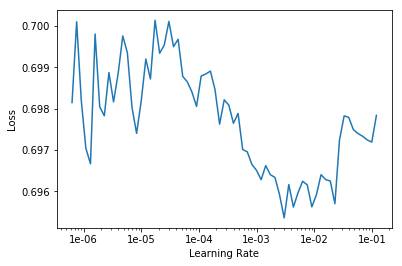

In [62]:
learn.lr_find()
learn.recorder.plot()

In [80]:
learn.fit_one_cycle(30, max_lr=1e-3)

Total time: 00:55
epoch  train_loss  valid_loss  accuracy
1      0.694043    0.694633    0.476000  (00:01)
2      0.693227    0.693842    0.510000  (00:01)
3      0.692341    0.693214    0.520000  (00:02)
4      0.691532    0.693981    0.516000  (00:01)
5      0.690240    0.693385    0.536000  (00:01)
6      0.688261    0.694868    0.502000  (00:01)
7      0.684323    0.696151    0.514000  (00:01)
8      0.679574    0.703019    0.466000  (00:01)
9      0.670428    0.706717    0.494000  (00:01)
10     0.659853    0.717627    0.482000  (00:01)
11     0.647399    0.731758    0.482000  (00:01)
12     0.630531    0.734997    0.490000  (00:01)
13     0.612728    0.781713    0.494000  (00:01)
14     0.595601    0.755801    0.476000  (00:01)
15     0.576510    0.771777    0.482000  (00:01)
16     0.556412    0.786781    0.478000  (00:01)
17     0.537086    0.798632    0.478000  (00:02)
18     0.518724    0.815592    0.484000  (00:02)
19     0.501062    0.828895    0.476000  (00:02)
20     0.48

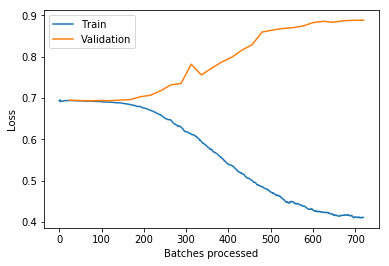

In [81]:
learn.recorder.plot_losses()

In [33]:
net(data.train_ds[0][0].data), net(data.train_ds[3][0].data)

(tensor([[ 2.2482, -2.3293]], grad_fn=<ThAddmmBackward>),
 tensor([[-2.8670,  2.5273]], grad_fn=<ThAddmmBackward>))

In [34]:
preds, targs = learn.get_preds()

In [206]:
#targs.view(-1,1)

In [207]:
#preds

In [35]:
i = 0
preds[i], targs[i]

(tensor([0.0346, 0.9654]), tensor(0))

In [36]:
data.train_ds[0], data.train_ds[3]

((Image (1, 4, 50), Category 0), (Image (1, 4, 50), Category 1))

In [37]:
learn.predict(data.train_ds[0][0]), learn.predict(data.train_ds[3][0])

((Category 0, tensor(0), tensor([0.9898, 0.0102])),
 (Category 1, tensor(1), tensor([0.0045, 0.9955])))

In [38]:
learn.save('epoch15')

In [39]:
learn.load('epoch15')

Learner(data=ImageDataBunch;
Train: LabelList
y: CategoryList (2000 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: .
x: SeqItemList (1500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;
Valid: LabelList
y: CategoryList (2000 items)
[Category 0, Category 0, Category 0, Category 1, Category 1]...
Path: .
x: SeqItemList (500 items)
[Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50), Image (1, 4, 50)]...
Path: .;
Test: None, model=Sequential(
  (0): Lambda()
  (1): Conv1d(4, 32, kernel_size=(12,), stride=(1,))
  (2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (3): Lambda()
  (4): Linear(in_features=288, out_features=16, bias=True)
  (5): ReLU()
  (6): Linear(in_features=16, out_features=2, bias=True)
), opt_func=functools.partial(<class 'torch.optim.adam.Adam'>, betas=(0.9, 0.99)), loss_func=<function cross_entropy at 0x1a1881ff28>, metrics=[<fu

In [82]:
interpret = ClassificationInterpretation.from_learner(learn)

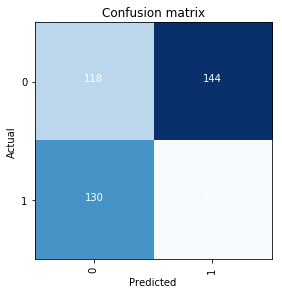

In [83]:
interpret.plot_confusion_matrix()